In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

In [52]:
#import data
src=r"W:\VUB\main_research\scripts\wetland_model\wetland-aquifer interaction\Wetland_Model\Wetland_Model"
p=pd.read_excel(src+"/p.xlsx")
obs_water_table=pd.read_excel(src+"/watertable.xlsx")
wl_wetland=pd.read_excel(src+"/wl_wetland.xlsx")

#evapotranspiration data
lhc=pd.read_excel(src+"/lhc.xlsx", names=['lhc'])
n2=pd.read_excel(src+"/n2.xlsx", names=['n2'])
new_epm=pd.read_excel(src+"/pet.xlsx")
psc=pd.read_excel(src+"/psc.xlsx", names=['psc'])
ssvpc=pd.read_excel(src+"/ssvpc.xlsx", names=['ssvpc'])

#replace zero values with nan in the observed water table depth
obs_water_table['water_table_depth'].replace(0, np.nan, inplace=True)
wl_wetland['wl_wetland'].replace(0, np.nan, inplace=True)

In [53]:
obs_water_table.min(), obs_water_table.max(), obs_water_table.mean()

(water_table_depth    131.3
 dtype: float64,
 water_table_depth    324.4
 dtype: float64,
 water_table_depth    238.428738
 dtype: float64)

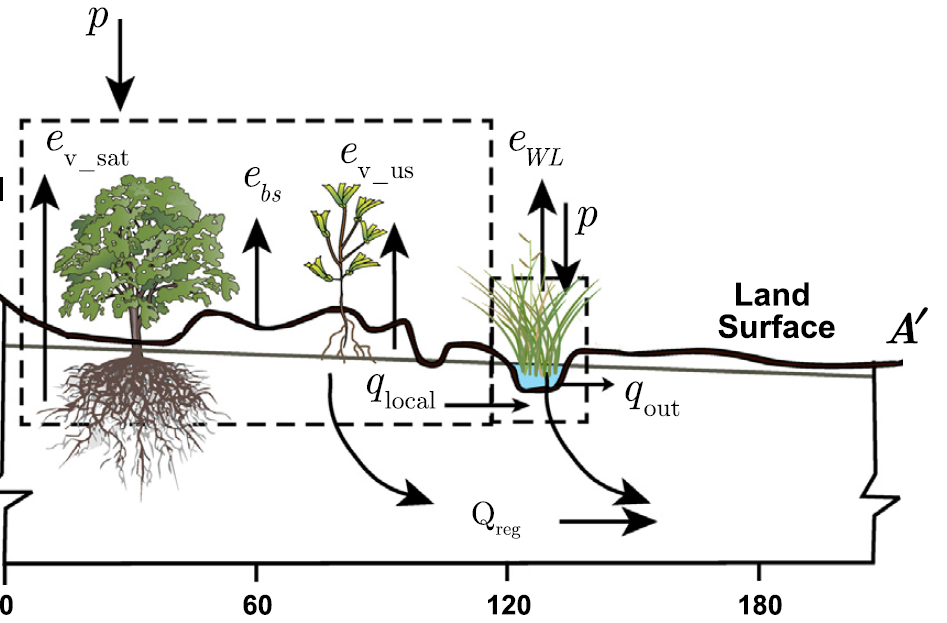

In [54]:
# Displaying the image
img_path = "schematic_representation.png"  # Ensure this file exists in the same directory
Image(filename=img_path, width=550, height=300)

In [55]:
#model parameters 
A1 = 38755
# A2 = 10000
Kh_GWlocal = 200 # characteristic hydraulic conductivity to calculate subsurface local groundwater flow
Kh_GWout = 1800 # hydraulic conductivity outflow
Kh_GWreg = 1 # hydraulic conductivity regional
L_GWlocal = 3300 # distance between riparian area and wetland
L_GWout = 3000 # outflow distance
L_GWreg = 3e5 # regional distance of groundwater flow
M = 0.9 # proportion of land covered by vegetation
MeanRootnew = 200 # mean root depth (cm)
kevap_BS = 1.7 # evaporation coefficient from bare soil
kv_WL = 1.5 # plant efficiency coefficient, wetland
kveg = 1.1 # evaporation coefficient from vegetation
kvegsat = 0.9 # evaporation coefficient from saturated zone
LAI=4.5 # leaf area index
n = 0.20 # soil porosity
phi_GW = n
phi_GWlocal = n
phi_GWout = n
ref_elev = 335.355 * 100
ref_elev_WL = 328.973 * 100
r_P=0.2 # proportion of precipitation that runs off
sfc = 0.45 # soil field capacity
s_initial = sfc*0.5 #initial soil moisture content
s_molecular_suction = 0.05 # soil water content corresponding to molecular suction pF6.0-7.0
s_sce = 0.10 # soil moisture level at which stomatal closure is fully completed (could also be substituted by wilting point)
s_scs = 0.45 # soil moisture level at which stomatal closure begins (could also be substituted by sfc)
y_seepage = 0

#xxxxxxxxxxxxxxxxxx-------------------------------------------------------------------------------
#Initialize water balance variables and variable catchment properties as zeros arrays
len_sim=len(p)# length of simulation based on length of input data

A_ratio = np.zeros(len_sim).reshape(len_sim, 1)
A2 = np.zeros(len_sim).reshape(len_sim, 1) # wetland area changes with t depending on the water level
CALCdeltaH_GW = np.zeros(len_sim).reshape(len_sim, 1)
CALCdeltaH_WL = np.zeros(len_sim).reshape(len_sim, 1)
day = np.zeros(len_sim).reshape(len_sim, 1)
deltaH_groundwater = np.zeros(len_sim).reshape(len_sim, 1)
deltaH_wetland = np.zeros(len_sim).reshape(len_sim, 1)
evap_BS = np.zeros(len_sim).reshape(len_sim, 1) #Bare soil evaporation
eb_US = np.zeros(len_sim).reshape(len_sim, 1) #evaporation from unsaturated zone
eb_US_cont_to_s = np.zeros(len_sim).reshape(len_sim, 1)
evap_BS_mm = np.zeros(len_sim).reshape(len_sim, 1) #evaporation from saturated zone
ep_WL = np.zeros(len_sim).reshape(len_sim, 1) #evaporation from wetland
eveg_sat = np.zeros(len_sim).reshape(len_sim, 1) #evaporation from saturated zone by vegetation
eveg_sat_cont_to_y = np.zeros(len_sim).reshape(len_sim, 1)
eveg_us = np.zeros(len_sim).reshape(len_sim, 1) #evaporation from unsaturated zone by vegetation
eveg_us_cont_to_s = np.zeros(len_sim).reshape(len_sim, 1)
gradient_local = np.zeros(len_sim).reshape(len_sim, 1) #gradient of local ground water flow
gradient_outflow = np.zeros(len_sim).reshape(len_sim, 1) #gradient of wetland outflow
Inf_cont_to_s_cm = np.zeros(len_sim).reshape(len_sim, 1)
Inf_cont_to_s_moist = np.zeros(len_sim).reshape(len_sim, 1)
net_precipitation = np.zeros(len_sim).reshape(len_sim, 1)
moisture_dep_factor = np.zeros(len_sim).reshape(len_sim, 1) #moisture depletion factor
plant_stress_factor = np.zeros(len_sim).reshape(len_sim, 1)
Q_GWreg = np.zeros(len_sim).reshape(len_sim, 1) #regional groundwater flow
Qss_GW = np.zeros(len_sim).reshape(len_sim, 1) #steady state groundwater flow
qGW_Local = np.zeros(len_sim).reshape(len_sim, 1)
qGW_out = np.zeros(len_sim).reshape(len_sim, 1)
qLOCAL_GW = np.zeros(len_sim).reshape(len_sim, 1)
qLOCAL_WL = np.zeros(len_sim).reshape(len_sim, 1)
Recharge = np.zeros(len_sim).reshape(len_sim, 1)
recharge_cont_to_y = np.zeros(len_sim).reshape(len_sim, 1)
Rlinear = np.zeros(len_sim).reshape(len_sim, 1)
R_us = np.zeros(len_sim).reshape(len_sim, 1) #recharge from unsaturated zone
s = np.zeros(len_sim).reshape(len_sim, 1)
water_table_elevation = np.zeros(len_sim).reshape(len_sim, 1) #groundwater elevation (water_table_elevation)
wetland_wl_elev = np.zeros(len_sim).reshape(len_sim, 1)
tR_local = np.zeros(len_sim).reshape(len_sim, 1) #local response time
tR_out = np.zeros(len_sim).reshape(len_sim, 1) #outflow response time
water_level_wetland = np.zeros(len_sim).reshape(len_sim, 1) # to be changed to actual observed water level in wetland
water_table_depth = np.zeros(len_sim).reshape(len_sim, 1) # to be changed to actual observed water table depth
WSC = np.zeros(len_sim).reshape(len_sim, 1)
y = np.zeros(len_sim).reshape(len_sim, 1)
y_rech = np.zeros(len_sim).reshape(len_sim, 1)
y_WL = np.zeros(len_sim).reshape(len_sim, 1)
net_p_input = np.zeros(len_sim).reshape(len_sim, 1)   
run_off = np.zeros(len_sim).reshape(len_sim, 1)
interception = np.zeros(len_sim).reshape(len_sim, 1)
s_max = np.zeros(len_sim).reshape(len_sim, 1)
delta_s = np.zeros(len_sim).reshape(len_sim, 1)

#xxxxxxxxxxxxxxxxxx-------------------------------------------------------------------------------

#initial conditions
interception[0]=0.05*LAI
net_precipitation[0]=p['p'][0]-interception[0]
s[0]=sfc*0.5 #initial soil moisture content
y[0]=obs_water_table['water_table_depth'][0] #initial water table depth (thickness of unsaturated zone) (cm)
WSC[0]=n*y[0]*(sfc-s[0]) #initial water storage in the soil
water_table_elevation[0]=ref_elev-y[0] #initial groundwater elevation
y_WL[0]=0 #initial water level in wetland
wetland_wl_elev[0]=y_WL[0]+ref_elev_WL #water level in wetland in reference to a datum
A2[0]=(9555.95988+8644.93182)/2
y_rech[0]=0
moisture_dep_factor[0]=0.05
A_ratio[0]=A1/A2[0]
gradient_local[0]=(water_table_elevation[0]-wetland_wl_elev[0])/L_GWlocal #gradient between local gw and wetland
tR_local[0]=L_GWlocal*phi_GWlocal/(Kh_GWlocal*gradient_local[0]) #local response time
qLOCAL_GW[0]=(water_table_elevation[0]-wetland_wl_elev[0])/tR_local[0] #local subsurface flow component

Q_GWreg[0]=Kh_GWreg*((water_table_elevation[0]-wetland_wl_elev[0])/(phi_GW*L_GWreg))

gradient_outflow[0]=(water_table_elevation[0]-wetland_wl_elev[0])/L_GWout
tR_out[0]=L_GWout*n/(Kh_GWout*gradient_outflow[0])
qGW_out[0]=(water_table_elevation[0]-wetland_wl_elev[0])/tR_out[0]
run_off[0]=0


In [56]:
qLOCAL_GW[0],Q_GWreg[0]

(array([19.77006428]), array([0.00773333]))

In [57]:
dt=1
for time in range(1,len_sim-1):
    #calculate interception

    interception[time] = min(p['p'][time], 0.05*LAI ) #Zhang et al., 2002 (An integrated model of soil, hydrology, and vegetation for carbon dynamics in wetland ecosystems)
    
    # Calculate water storage capacity of the soil. This can be considered as the maximum amount of water the soil can hold at a given time
    WSC[time] = max(0,n * y[time] * (sfc - s[time]))

    s_max[time] = max(0,n * y[time]) # Maximum storage volume of the soil [Farmer et al., 2000: Climate, soil, and vegetation controls upon the variability of water Downward approach to water balance analysis]

    # Calculate net_precipitation
    #net_precipitation[time] = p['p'][time] * dt
    if p['p'][time] - interception[time] > 0:
        net_precipitation[time] = (p['p'][time] - interception[time])*dt
    else:
        net_precipitation[time] = 0

    """////////////////////// Recharge//////////////////////"""

    # Calculate recharge and update soil moisture content
    if net_precipitation[time] >= WSC[time]:
        # Update soil moisture content
        s[time+1] = sfc
        Recharge[time] = net_precipitation[time]-WSC[time] 
        Inf_cont_to_s_moist[time] = WSC[time]  # Infiltration contribution to soil moisture
        # Calculate runoff as the excess water beyond WSC
        #run_off[time] = net_precipitation[time] - WSC[time]

    else:
        Recharge[time] = net_precipitation[time]  # All net precipitation recharges the soil
        s[time + 1] = s[time] + (net_precipitation[time] / (n * y[time]))
        Inf_cont_to_s_moist[time] = net_precipitation[time]

        # No runoff if net precipitation does not exceed WSC
        run_off[time] = 0
        Inf_cont_to_s_moist[time] = WSC[time]
    
    if WSC[time] == 0:
        run_off[time] = net_precipitation[time]
        Recharge[time] = 0
        s[time + 1] = sfc
        #y[time + 1] = 0

    
    """////////////////////// Soil Moisture//////////////////////"""

    #first update of water table depth
    recharge_cont_to_y[time] = Recharge[time] / (n * (1 - sfc))

    y[time + 1] = y[time] - (Recharge[time] / (n * (1 - sfc))) #if no recharge, water table depth remains the same

    # Calculate bare soil evaporation
    if s[time + 1] <= s_molecular_suction:
        evap_BS[time] = 0

    elif s[time + 1] > s_molecular_suction and s[time + 1] < sfc:
        moisture_dep_factor[time] = 0.25 * (1 - np.cos(np.pi * (s[time + 1] - s_molecular_suction) / (sfc - s_molecular_suction))) ** 2
        evap_BS_mm[time] = n2['n2'][time] / (lhc['lhc'][time] * (ssvpc['ssvpc'][time] + (psc['psc'][time] / moisture_dep_factor[time])))
        evap_BS[time] = evap_BS_mm[time] / 10  # Convert mm/day to cm/day
        
    elif s[time + 1] >= sfc:
        evap_BS[time] = new_epm['pet'][time]/10  # Convert mm/day to cm/day

    # Calculate unsaturated zone evaporation
    eb_US[time] = (1 - M) * kevap_BS * evap_BS[time]

    if y[time] != 0:
        eb_US_cont_to_s[time] = eb_US[time] / (n * y[time]) * dt

    else:
        eb_US_cont_to_s[time] = 0
    
    #///////////// second update of soil moisture content//////////////////////

    # Update soil moisture content due to unsaturated evaporation
    if y[time + 1] > 0:  # Check if (water table is below the surface)
        s[time + 1] -= (eb_US[time] / (n * y[time+1])) * dt

    # else:
    #     # When y is zero, indicating the saturated layer is at the surface
    #     # Set soil moisture content to a maximum value
    #     s[time + 1] = 

    # Calculate plant stress factor
    if s[time + 1] >= s_scs:
        plant_stress_factor[time] = 1
        
    elif s[time + 1] >= s_sce and s[time + 1] < s_scs:
        plant_stress_factor[time] = (s[time + 1] - s_sce) / (s_scs - s_sce)

    elif s[time + 1] < s_sce:
        plant_stress_factor[time] = 0

    # Calculate proportion of roots in the unsaturated zone
    if y[time] != 0:
        R_us[time] = np.exp(-(1 / MeanRootnew) * y[time])
    else:
        R_us[time] = 0

    # Calculate vegetation evaporation from unsaturated zone
    eveg_us[time+1] = M * kveg * plant_stress_factor[time+1] * (1 - R_us[time+1]) * new_epm['pet'][time+1]

    if y[time+1] != 0:
        eveg_us_cont_to_s[time] = eveg_us[time] / (n * y[time + 1]) * dt
    else:
        eveg_us_cont_to_s[time] = 0

    #///////////// third and last update of soil moisture content//////////////////////
    #Update soil moisture content due to vegetation evaporation

    if y[time + 1] > 0:
    # Calculate the change in soil moisture
        delta_s[time] = (eveg_us[time] / (n * y[time + 1])) * dt
    # Update soil moisture using max() to ensure it remains non-negative
        s[time + 1] = max(0, s[time + 1] - delta_s[time])

    # else:
    #     # When y is zero, indicating the saturated layer is at the surface
    #     # Set soil moisture content to a maximum value or another appropriate value
    #     s[time + 1] = sfc

    """Saturated Excess run off"""
    # #when soil moisture content is at field capacity, precipitation becomes excess and runs off

    
    """//////////Groundwater flow///////////"""
    # calculate saturated zone evaportanspiration from vegetation
    eveg_sat[time] = M * kvegsat * R_us[time] * new_epm['pet'][time]

    eveg_sat_cont_to_y[time] = eveg_sat[time] / (n * (1 - sfc))

    #local subsurface groundwater flow component
    qLOCAL_GW[time]=(qGW_Local[time]/(n*(1-sfc)))*dt

    #steady state regional groundwater flow
    Qss_GW[time]=(Q_GWreg[time]/(n*(1-sfc)))*dt

     # Update water table depth due to saturated zone evaporation by vegetation
    y[time + 1] += (eveg_sat[time] / (n * (1 - sfc))) * dt

    y[time + 1] += Qss_GW[time] * dt

    y[time + 1] +=  qLOCAL_GW[time] * dt

    # # Ensure the water table does not exceed the surface level
    #y[time+1] = min(y[time+1], 0)


    # Calculate groundwater elevation

    water_table_elevation[time+1] = ref_elev - y[time+1]

    """+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++"""
    
    """//////////WETLAND WATER BALANCE///////////"""
    """wetland receives water from precipitation and groundwater flow from the riparian area (qlocal) and loses
       it through evaporation, outflow to the regional groundwater system (Qreg) and local subsurface outflow to the aquifer"""
    
    # Calculate wetland water level
    ep_WL[time] = kv_WL * new_epm['pet'][time] #evaporation from wetland

    # First update of wetland water level: considering only precipitation and evaporation
    net_p_input[time]=p['p'][time]-ep_WL[time] #net precipitation input

    y_WL[time + 1] = y_WL[time] + (p['p'][time] - ep_WL[time]) * dt #precipitation minus evaporation

    #second update of wetland water level: considering local groundwater inflow from riparian area
    qLOCAL_WL[time]=qGW_Local[time]*A_ratio[time] *dt

    y_WL[time + 1] += qLOCAL_WL[time]

    #third update of wetland water level: considering outflow due to regional groundwater flow
    y_WL[time + 1] -= Q_GWreg[time]*dt #

    y_WL[time + 1] -= qGW_out[time]*dt #

    #y_WL[time + 1] = min(400, y_WL[time + 1])

    # Calculate wetland water level elevation
    wetland_wl_elev[time+1] = y_WL[time+1] + ref_elev_WL

    #Calculation of regional groundwater flow
    Q_GWreg[time+1] = Kh_GWreg * ((water_table_elevation[time+1] - wetland_wl_elev[time+1]) / (phi_GW * L_GWreg))

    if water_table_elevation[time+1] - wetland_wl_elev[time+1] <0:
        Q_GWreg[time+1] = 0

    #----Seepage from wetland to aquifer-----
    gradient_outflow[time+1]=(water_table_elevation[time+1]-wetland_wl_elev[time+1])/L_GWout
    tR_out[time+1]=L_GWout*n/(Kh_GWout*gradient_outflow[time+1])

    if tR_out[time+1]!=0:
        qGW_out[time+1]=(water_table_elevation[time+1]-wetland_wl_elev[time+1])/tR_out[time+1]

    if y_WL[time+1]<=y_seepage:
        qGW_out[time+1]=0

    if water_table_elevation[time+1]-wetland_wl_elev[time+1]<0:
        tR_out[time+1]=0
        qGW_out[time+1]=0

    #Local groundwater flow component in groundwater
    gradient_local[time+1]=(water_table_elevation[time+1]-wetland_wl_elev[time+1])/L_GWlocal
    tR_local[time+1]=L_GWlocal*phi_GWlocal/(Kh_GWlocal*gradient_local[time+1])

    if tR_out[time+1]!=0:
        qGW_Local[time+1]=(water_table_elevation[time+1]-wetland_wl_elev[time+1])/tR_local[time+1]


    if water_table_elevation[time+1]-wetland_wl_elev[time+1]<0:
        tR_local[time+1]=0
        qLOCAL_GW[time+1]=0

    # # Calculate wetland area
    if y_WL[time + 1] >= 1400:
        A2[time + 1] = (12128.89561 + 11896.10253) / 2

    elif 1400 > y_WL[time + 1] >= 0:
        A2[time + 1] = (1.267e-14 * y_WL[time + 1] ** 9 - 
                        1.02e-11 * y_WL[time + 1] ** 8 + 
                        3.243e-9 * y_WL[time + 1] ** 7 - 
                        5.098e-7 * y_WL[time + 1] ** 6 + 
                        4.038e-5 * y_WL[time + 1] ** 5 - 
                        0.001458 * y_WL[time + 1] ** 4 + 
                        0.01874 * y_WL[time + 1] ** 3 + 
                        0.5618 * y_WL[time + 1] ** 2 + 
                        6.617 * y_WL[time + 1] + 
                        99.23)

    elif y_WL[time + 1] < 0:
        A2[time + 1] = 62.38497

    # Calculate the ratio of wetland area to catchment area
    A_ratio[time + 1] = A1 / A2[time + 1]

    # Calculate the change in groundwater elevation
    CALCdeltaH_GW[time] = water_table_elevation[time + 1] - water_table_elevation[time]

    # Calculate the change in wetland water level
    CALCdeltaH_WL[time] = wetland_wl_elev[time + 1] - wetland_wl_elev[time]

    # Calculate the change in water table depth
    deltaH_groundwater[time] = y[time + 1] - y[time]

    # Calculate the change in water level in the wetland
    deltaH_wetland[time] = y_WL[time + 1] - y_WL[time]

    # # Calculate the change in soil moisture content
    # if y[time]!=0 and s[time+1]!=0:
    #     Inf_cont_to_s_cm[time] = net_precipitation[time] / (n * y[time])
    #     Inf_cont_to_s_moist[time] = net_precipitation[time] / (n * s[time])

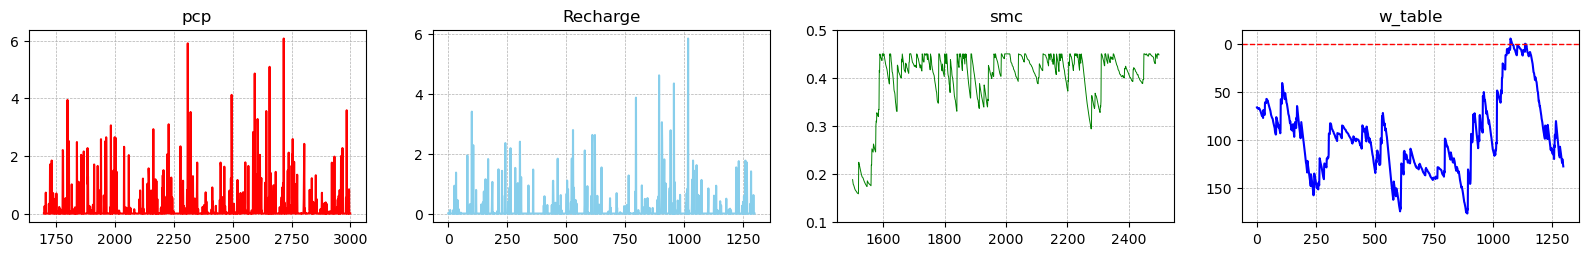

In [76]:
s_df=pd.DataFrame(s)

fig,[ax1,ax2,ax3,ax4]=plt.subplots(1,4,figsize=(20, 2.5))

#set spacing between subplots
plt.subplots_adjust(wspace=0.2)

ax1.plot(p['p'][1700:3000], c='r')
ax2.plot(Recharge[1700:3000], c='skyblue')
ax3.plot(s_df[1500:2500],c='g', linewidth=0.7)
ax3.set_ylim(0.1, 0.50)
ax4.plot(y[1700:3000], c='b')
ax4.axhline(y=0, color='r', linestyle='--', linewidth=1.0)
#ax3.set_ylim(100, 250)
#invert y axis
ax4.invert_yaxis()
for ax in [ax1, ax2, ax3, ax4]:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    #set grid spacing
    ax.xaxis.set_major_locator(plt.MaxNLocator(7))
    ax.set_title(['pcp','Recharge','smc','w_table'][[ax1,ax2,ax3,ax4].index(ax)])

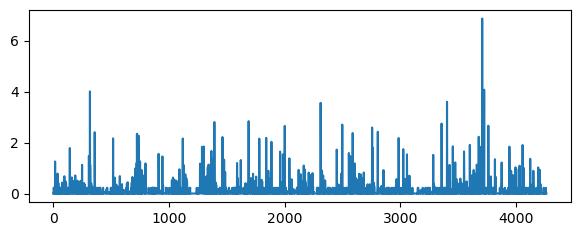

In [59]:
plt.figure(figsize=(7, 2.5))
r_df=pd.DataFrame(Recharge, columns=['recharge'])
plt.plot(-r_df['recharge']+p['p'])

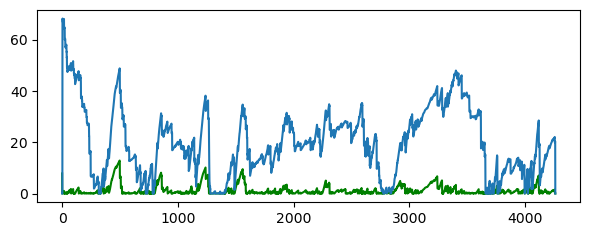

In [60]:
plt.figure(figsize=(7, 2.5))
plt.plot(WSC, c='g')
plt.plot(s_max)

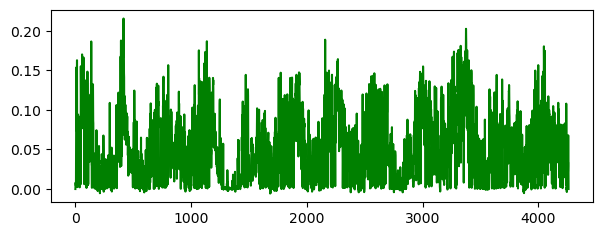

In [78]:
plt.figure(figsize=(7, 2.5))
plt.plot(eb_US, c='g')

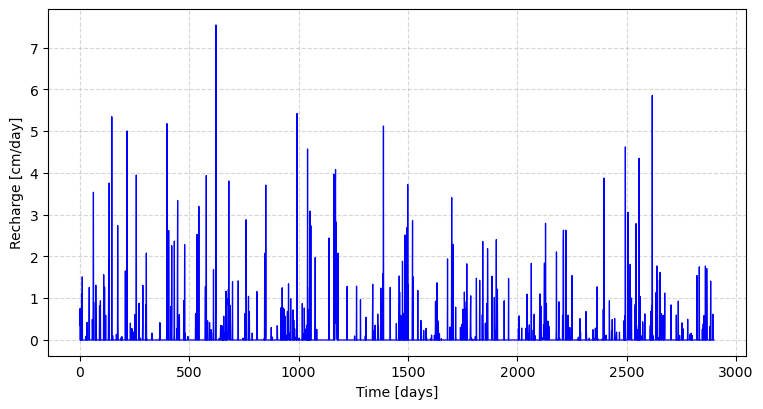

In [61]:
plt.figure(figsize=(9, 4.5))
#plt.plot(Recharge, c='r')
plt.plot(Recharge[100:3000], c='blue', linewidth=0.9)
#plt.ylim(0.05, 0.55)
#plt.ylabel('Volumetric coil Moisture Content[-]')
plt.ylabel('Recharge [cm/day]')
plt.xlabel('Time [days]')
plt.grid(alpha=0.5, linestyle='--') 

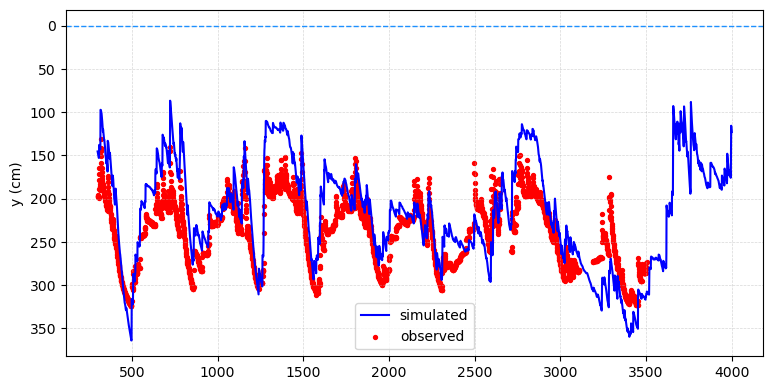

In [62]:
# Create subplots
fig, ax = plt.subplots(figsize=(9, 4.5))

y_mod=pd.DataFrame(y+120)
y_mod.columns=['y']
y_mod['y'][300:4000].plot(ax=ax, c='b', label='simulated')
#obs_water_table.columns=['observed']
plt.scatter(obs_water_table[300:4000].index, obs_water_table[300:4000], c='r', label='observed', s=8)
ax.invert_yaxis()
ax.axhline(y=0, color='dodgerblue', linestyle='--', linewidth=1.0)

# Set labels and legend
ax.set_ylabel('s_df')
ax.set_ylabel('y (cm)')
ax.legend(loc='best')
ax.grid(alpha=0.5, linestyle='--', linewidth=0.5)

plt.show()

In [63]:
#compute bias between simulated and observed water table depth
bias=y_mod['y'][0:4000]-obs_water_table['water_table_depth'][0:4000]
bias.mean()

-11.780195397616824

Text(0.5, 0, 'observed water table depth (cm)')

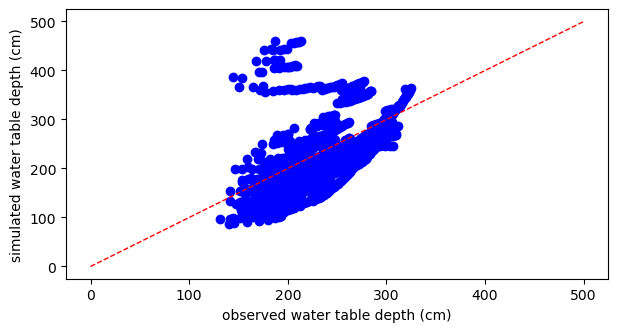

In [64]:
## scatterplot of observed and simulated water table depth
fig, ax = plt.subplots(figsize=(7, 3.5))

ax.scatter(obs_water_table['water_table_depth'][10:3000],y_mod['y'][10:3000], c='b', label='simulated')
ax.plot([0, 500], [0, 500], color='r', linestyle='--', linewidth=1.0)
ax.set_ylabel('simulated water table depth (cm)')
ax.set_xlabel('observed water table depth (cm)')


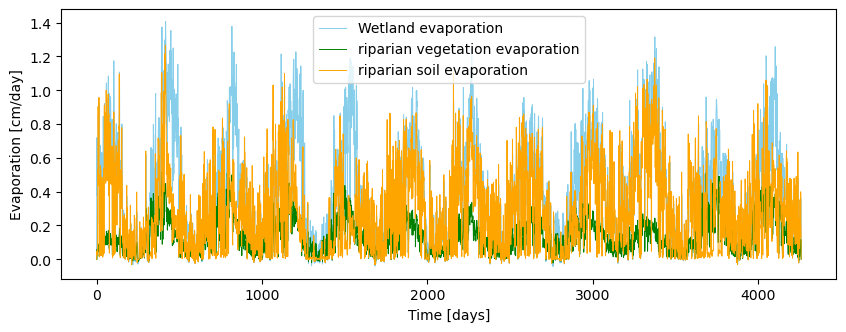

In [65]:
fig, ax = plt.subplots(figsize=(10, 3.5))
plt.plot(np.squeeze(ep_WL), c='skyblue', linewidth=0.7, label='Wetland evaporation')
plt.plot(np.squeeze(eveg_sat), c='green', linewidth=0.7, label='riparian vegetation evaporation')
plt.plot(np.squeeze(evap_BS), c='orange', linewidth=0.7, label='riparian soil evaporation')
#plt.plot(np.squeeze(p['p']), linewidth=0.7, c='orange', label='precipitation')
plt.ylabel('Evaporation [cm/day]')
plt.xlabel('Time [days]')
plt.legend(loc='best')

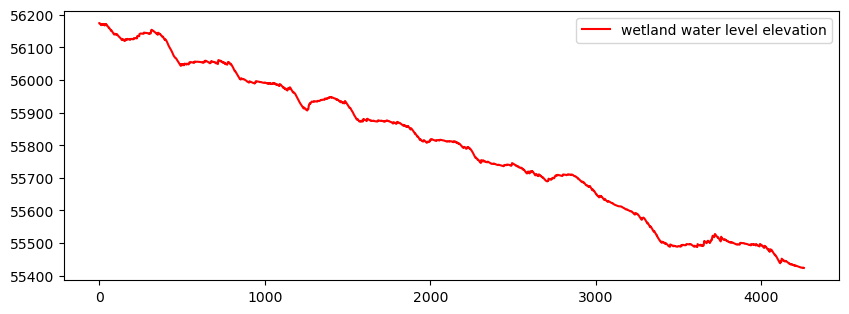

In [66]:
fig, ax = plt.subplots(figsize=(10, 3.5))
# plt.plot(np.squeeze(water_table_elevation[10:]), c='g', label="water table elevation")
plt.plot(wetland_wl_elev[5:], c='r', label="wetland water level elevation")
plt.legend(loc='best')

In [67]:
wetland_wl_elev[5:]-ref_elev_WL

array([[23276.86935576],
       [23277.15122752],
       [23276.66191889],
       ...,
       [22527.32775421],
       [22526.96937345],
       [22526.79663596]])

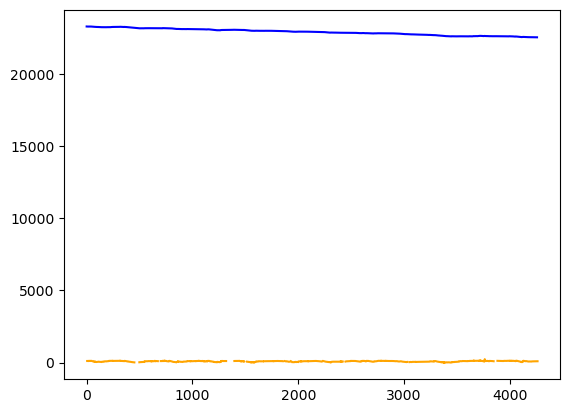

In [68]:
# plt.plot(np.squeeze((wetland_wl_elev-ref_elev_WL)[5:]), c='g')
plt.plot(np.squeeze(y_WL[5:]), c='b')
plt.plot(np.squeeze(wl_wetland[5:]), c='orange')

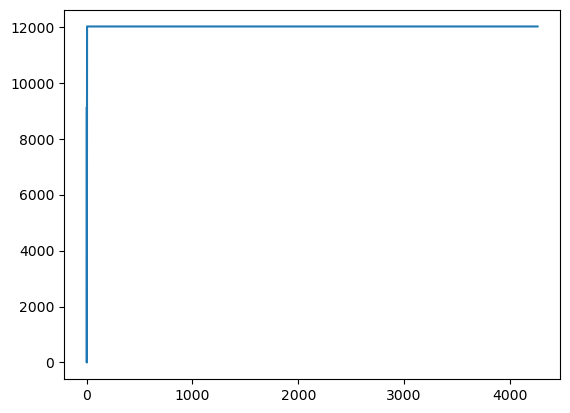

In [69]:
plt.plot(np.squeeze(A2))

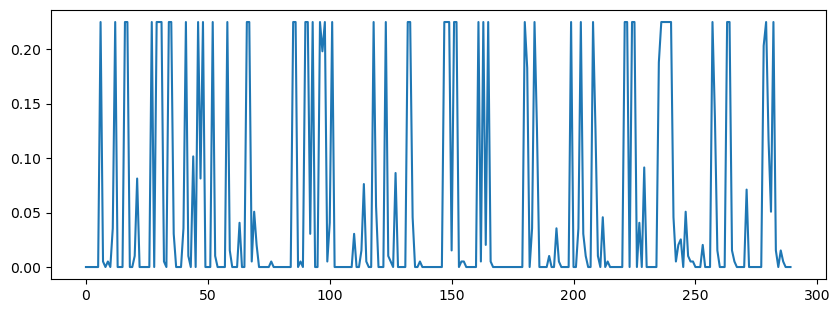

In [70]:
plt.figure(figsize=(10, 3.5))
#plt.plot(np.squeeze(run_off[10:]))
plt.plot(np.squeeze(interception[10:300]))

In [71]:
#model parameters backup
sfc=0.45 #soil field capacity
n=0.3 #soil porosity
L_GWlocal=3300 #distance btn riparian area and wetland
Kh_GWlocal=50 #xtic hydraulic conductivity to calc. subsurface local gw flow
L_GWreg=3e5 #L regional
Kh_GWreg=10 #K regional
L_GWout=3000 #L outflow
Kh_GWout=1770 #K outflow
s_molecular_suction=0.04 #swc corresponding to molecular suction pF6.0-7.0
kevap_BS=1.5 #evaporation coefficient from bare soil
kveg=0.27 #evaporation coefficient from vegetation
kvegsat=0.9 #evaporation coefficient from saturated zone
M=0.74#Proportion of land covered by vegetation
kv_WL=0.75 #plant efficiency coefficient
s_scs=0.15 #soil moisture level at which stomatal closure begins 0.2732 0.2732
s_sce=0.10 #soil moisture level at which stomatal closure is fully completed
MeanRootnew=200 #mean root depth (cm)


s_initial=sfc
ref_elev=332.355*100
ref_elev_WL=328.973*100
phi_GW=n
phi_GWlocal=n
phi_GWout=n   
y_seepage=0
A1=38755


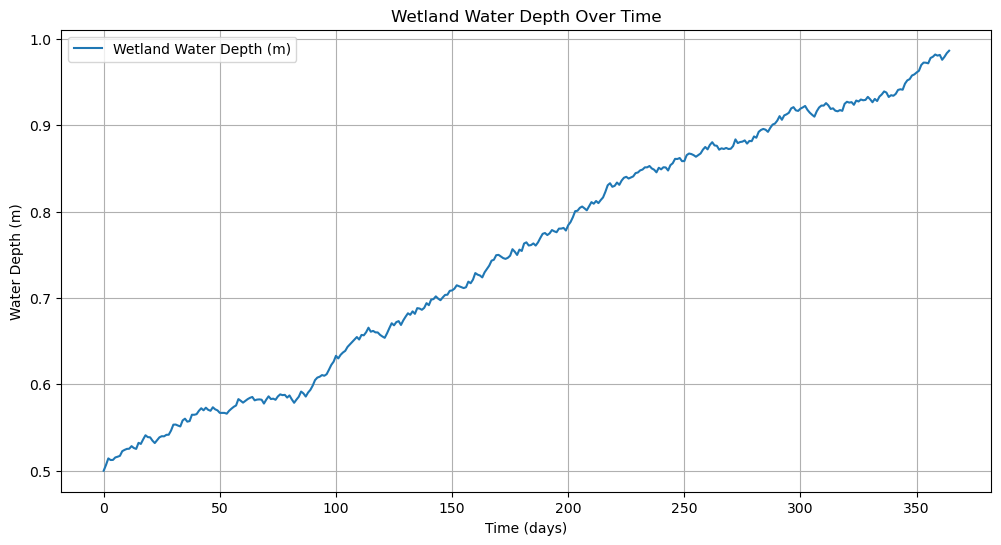

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants and parameters
dt = 1  # time step in days
time_steps = 365  # simulation for one year
initial_depth = 0.5  # initial water depth in meters

# Fluxes (example values, replace with actual data)
precipitation = np.random.uniform(0, 0.01, time_steps)  # daily precipitation in meters
transpiration = np.random.uniform(0, 0.005, time_steps)  # daily transpiration in meters
outflow = np.random.uniform(0, 0.002, time_steps)  # daily outflow in meters

# Initialize arrays
depth = np.zeros(time_steps)
depth[0] = initial_depth

# Simulation loop
for t in range(1, time_steps):
    P = precipitation[t]
    T = transpiration[t]
    O = outflow[t]
    delta_h = (P - T - O) * dt
    depth[t] = depth[t-1] + delta_h

    # Ensure the depth does not exceed 1 meter
    if depth[t] > 1:
        depth[t] = 1

    # Ensure the depth does not go below 0
    if depth[t] < 0:
        depth[t] = 0

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(depth, label='Wetland Water Depth (m)')
plt.xlabel('Time (days)')
plt.ylabel('Water Depth (m)')
plt.title('Wetland Water Depth Over Time')
plt.legend()
plt.grid()
plt.show()


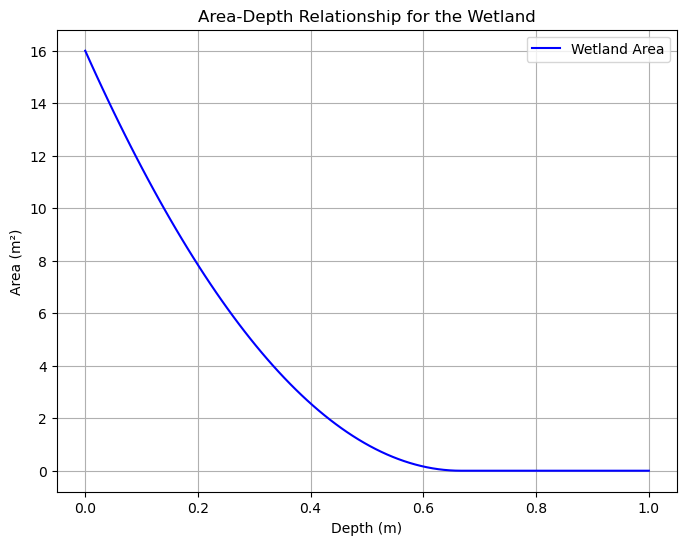

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function to calculate the area at a given depth
def calculate_area(depth, W_top, L_top, slope_ratio):
    W = W_top - 6 * depth
    L = L_top - 6 * depth
    if W <= 0 or L <= 0:
        return 0  # if dimensions go negative, area is zero (this handles edge cases)
    return W * L

# Wetland top dimensions and slope ratio
W_top = 4  # meters
L_top = 4  # meters
slope_ratio = 3  # 1:3 slope

# Generate a range of depths from 0 to 1 meter
depths = np.linspace(0, 1, 100)

# Calculate the corresponding areas
areas = [calculate_area(depth, W_top, L_top, slope_ratio) for depth in depths]

# Plot the area-depth relationship
plt.figure(figsize=(8, 6))
plt.plot(depths, areas, label='Wetland Area', color='blue')
plt.xlabel('Depth (m)')
plt.ylabel('Area (m²)')
plt.title('Area-Depth Relationship for the Wetland')
plt.legend()
plt.grid()
plt.show()
